# Dylan's Solvers

### Facility Location

High level outline:
* Placing locations to minimize something (where to drop off to minimize energy)
* Use approximation alg/solver
* Mark drop off locations (iterate through 1 → #homes locations)
* Then find tour through locations (shortest path run each time)
* Think about k means too


Facility Location Problem Notes:
* Clients: Homes
* Facilities: All other points as potential facilities 
* distance function (can run dijkstras or something)
* cost function: no cost for placing
* minimize 2/3 * distance from start + 1 * distance to closest homes in the "cluster"

Plan:
* Try older approximation algorithms
* Try newer k clustering ones
* Try some form of k means (?)

### Uncapacitated FLP - if it's not metric 
* choose U = {all homes}
* S = {(i, A) for i in all other pointes and A in homes (choose every subset)}
* Use standard greedy for set cover: choose (i, A) that minimizes cost(i, A)/|(A intersect uncovered)|
* intuitively this picks a smaller cost that covers more
* libraries may exist to solve set cover
* dlx solves exact cover which is probably better

### Todo
* distance to each point currently in the set and reward ones that are closer (minimize this) - consider dist to other facilities into cost
* try other two fixes for metric and for adding the minimum of every distance

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import sys
sys.path.append('..')
from student_utils import adjacency_matrix_to_graph, is_valid_walk, cost_of_solution, convert_locations_to_indices
from solver_utils import parse_input
from visualize import plot_graph

In [148]:
from collections import defaultdict
def flp_solve(list_of_locations,
                  list_of_homes,
                  starting_car_location,
                  adjacency_matrix, solve
                  params=[]):
    mapping = defaultdict(int)
    for i in range(len(list_of_locations)):
        mapping[list_of_locations[i]] = i
    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    U = list_of_homes
    facilities = list_of_locations
    start = starting_car_location
    paths, distances = nx.floyd_warshall_predecessor_and_distance(G, weight='weight')
#     print(distances)
#     print(paths)
    print("ran all pairs")
    # Builds set S in polynomial time as opposed to powerset (exponential)
    def buildS():
        res = []
        for f in facilities:
            for s in range(1, len(U)):
                sorted_dist = sorted([(target, distances[mapping[f]][mapping[target]]) for target in U], key=lambda x: x[1])
                sorted_dist = sorted_dist[:s]
                A = set([t for t, _ in sorted_dist])
                cost = sum([s[1] for s in sorted_dist]) + (2/3) * distances[mapping[start]][mapping[f]]
                elem = {'facility': f, 
                        'A': A, 
                        'count': s, 
                        'cost': cost
                       } # facility, dictionary to see which elements are present, num elements, cost
                res.append(elem)
        return res
    S = buildS()
    print("Built S")
    uncovered = set(U)
    lst = [(s['cost']/s['count'], hash(s['facility'] + str(s['count'])), s) for s in S]
    result = set([])
    dropoff_mapping = defaultdict(list)
    while uncovered:
        smallest = min(lst, key = lambda x: x[0])
        lst.remove(smallest)
        smallest = smallest[2]
        result.add(smallest['facility'])
        dropoff_mapping[smallest['facility']] = list(smallest['A'])
        uncovered = uncovered.difference(smallest['A'])
        new_lst = []
        for _, h, elem in lst:
            if solve == 1:
                if elem['facility'] in result:
                    elem['cost'] -= distances[mapping[start]][mapping[elem['facility']]]
            if solve == 2:
                if elem['facility'] not in result:
                    elem['cost'] = sum([distances[mapping[s]][mapping[elem['facility']]] for s in elem['A']]) + (1/4) * sum([distances[mapping[r]][mapping[elem['facility']]] for r in result if r != start])
            intersect = len(elem['A'].intersection(uncovered))
            new_cost = float('inf')
            if intersect > 0:
                new_cost = elem['cost']/intersect
            new_lst.append((new_cost, h, elem))
        lst = new_lst
    print("computed dropoffs")
    #finding path between all
    traversal = [mapping[start]]
    dists = [(distances[traversal[-1]][mapping[r]], mapping[r]) for r in list(result) if r != start]
    dropoffs = [mapping[start]] if start in result else []
    print("computing traversal")
    def reconstruct_path(source, target, predecessors):
        if source == target:
            return []
        prev = predecessors[source]
        curr = prev[target]
        path = [target, curr]
        while curr != source:
            curr = prev[curr]
            path.append(curr)
        return list(reversed(path))
        
    while dists:
        n = min(dists, key= lambda x: x[0])
        dists.remove(n)
        n = n[1]
        dropoffs.append(n)
        traversal.extend(reconstruct_path(traversal[-1], n, paths)[1:])
        dists = [(distances[traversal[-1]][r], r) for _, r in dists]
    traversal.extend(reconstruct_path(traversal[-1], mapping[start], paths)[1:]) 
    print("done")
#     dropoffs_dict = {key: dropoff_mapping[key] for key in dropoff_mapping}
    dropoffs_dict = defaultdict(list)
    for h in convert_locations_to_indices(list_of_homes, list_of_locations):
        minValue = float('inf')
        minVertex = mapping[start]
        for i in traversal:
            if distances[h][i] < minValue:
                minValue = distances[h][i]
                minVertex = i
        dropoffs_dict[minVertex].append(h)
    dropoffs_dict = {key: dropoffs_dict[key] for key in dropoffs_dict}
    return traversal, dropoffs_dict


SyntaxError: invalid syntax (<ipython-input-148-876fca2eb208>, line 6)

Cost of MST 1140.0
The driving cost of your solution is 1140.0.
The walking cost of your solution is 0.
The total cost of your solution is 1140.0.

ran all pairs
Built S
computed dropoffs
computing traversal
done
Cost of FLP 1028.3333333333335
The driving cost of your solution is 641.3333333333334.
The walking cost of your solution is 387.0.
The total cost of your solution is 1028.3333333333335.

plotting ...


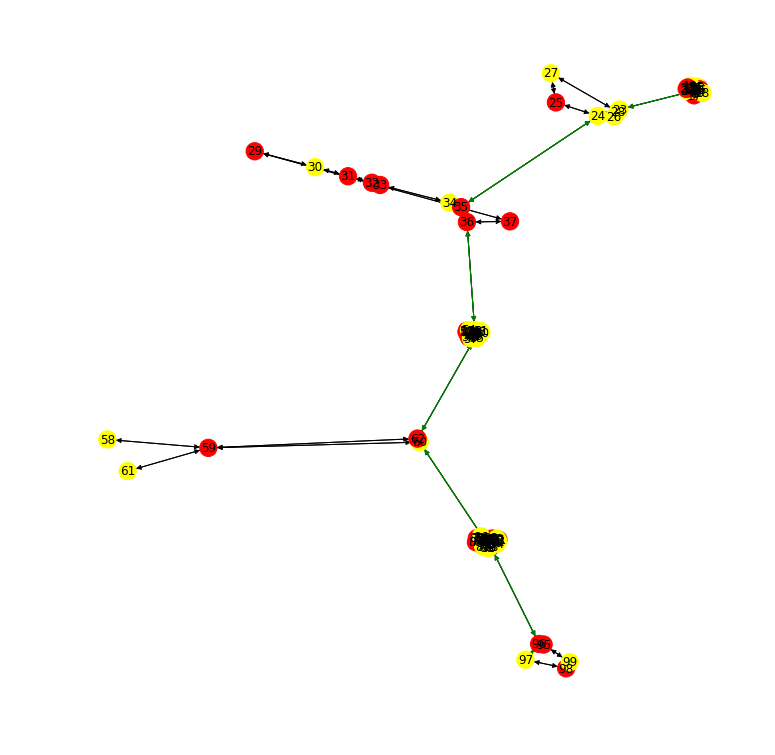

In [149]:
# input_path = './test_inputs/branching_20v_10h.in'
# input_path = '../inputs/164_100.in'
input_path = '../phase1/100.in'
(num_locations,
 num_houses,
 location_names,
 house_names,
 source,
 adj) = parse_input(input_path)

G, _ = adjacency_matrix_to_graph(adj)
traversal, dropoffs, _ = mst_dfs_solve(location_names, house_names, source, adj)
# print(dropoffs)
# print(traversal)
total, msg = cost_of_solution(G, traversal, dropoffs)
print("Cost of MST", total)
print(msg)

# traversal, dropoffs = dijkstra_greedy_solve(location_names, house_names, source, adj)
# # print(dropoffs)
# # print(traversal)
# dropoffs = {location_names.index(key): convert_locations_to_indices(dropoffs[key], location_names) for key in dropoffs}
# total, msg = cost_of_solution(G, traversal, dropoffs)
# print("Cost of Greedy", total)
# print(msg)

traversal, dropoffs = flp_solve(location_names, house_names, source, adj)
# print(dropoffs)
# print(traversal)
# dropoffs = {location_names.index(key): convert_locations_to_indices(dropoffs[key], location_names) for key in dropoffs}
# traversal = convert_locations_to_indices(traversal, location_names)
# for i in range(1, len(traversal)):
#     print(traversal[i - 1], traversal[i])
#     print("isEdge?", G.has_edge(traversal[i - 1], traversal[i]))

total, msg = cost_of_solution(G, traversal, dropoffs)
print("Cost of FLP", total)
print(msg)

edges_to_draw = []
for i in range(len(traversal) - 1):
    u, v = traversal[i], traversal[i + 1]
    edges_to_draw.append((u, v))
print("plotting ...") 
plot_graph(input_path,
           layout_style=nx.kamada_kawai_layout,
           show_edge_weights=False,
           edges_to_draw=edges_to_draw,
           directed=True)

### Naive Solver

In [140]:
def mst_dfs_solve(list_of_locations,
                  list_of_homes,
                  starting_car_location,
                  adjacency_matrix,
                  params=[]):
    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    
    mst = nx.minimum_spanning_tree(G)
    seen = set()
    traversal = []
    def dfs(u):
        if u not in seen:
            traversal.append(u)
            seen.add(u)
            for v in mst.neighbors(u):
                if v not in seen:
                    dfs(v)
                    traversal.append(u)
    dfs(list_of_locations.index(starting_car_location))
    
    dropoffs = {
        home: [home] for home in list_of_homes 
    }
    dropoffs = {location_names.index(key): convert_locations_to_indices(dropoffs[key], location_names) for key in dropoffs}
    return traversal, dropoffs

In [12]:
def dijkstra_greedy_solve(list_of_locations,
                          list_of_homes,
                          starting_car_location,
                          adjacency_matrix,
                          params=[]):
    G, _ = adjacency_matrix_to_graph(adjacency_matrix)
    remaining = set([list_of_locations.index(name) for name in list_of_homes])
    source = curr = list_of_locations.index(starting_car_location)
    
    path = []
    
    # Continue looping until no more TAs to drop off
    while remaining:
#         print(f"\n==== AT NODE #{curr} ====")
        path.append(curr)
        
        if curr in remaining:
#             print(f"DROPPED TA OFF AT {curr}")
            remaining.remove(curr)

        # Which direction should we move (if at all)?
        heuristics = {}
        for n in G.neighbors(curr):
#             print(n)
            distances, paths = nx.single_source_dijkstra(G, n)
            heuristics[n] = 0
            for h in remaining:
#                 if n == h:
#                     heuristics[n] += 2.0 # TODO: What should the heuristic be if you're at a house?
#                                          # Maybe just define as 1 / dist + 1
#                 else:
#                     heuristics[n] += 1 / distances[h]
                heuristics[n] += (1 / (distances[h] + 1)) ** 2 # 1/(dist+1)^2 heavily incentives closer houses
#             print(f"DISTANCES FROM {n}", distances)
        
#         print("HEURISTICS: ", heuristics)
        best_neighbor = max(list(heuristics.keys()), key=heuristics.get)
#         print("BEST NEIGHBOR: ", best_neighbor)
        curr = best_neighbor

    if curr != source:
        sp = nx.shortest_path(G, source=curr, target=source, weight='weight')
        path += sp
    
    dropoffs = {
        home: [home] for home in list_of_homes 
    }

    return path, dropoffs

In [104]:
G = nx.DiGraph()
def reconstruct_path(source, target, predecessors):
    if source == target:
        return []
    prev = predecessors[source]
    curr = prev[target]
    path = [target, curr]
    while curr != source:
        curr = prev[curr]
        path.append(curr)
    return list(reversed(path))
G.add_weighted_edges_from([('s', 'u', 10), ('s', 'x', 5),
    ('u', 'v', 1), ('u', 'x', 2), ('v', 'y', 1), ('x', 'u', 3),
    ('x', 'v', 5), ('x', 'y', 2), ('y', 's', 7), ('y', 'v', 6)])
predecessors, _ = nx.floyd_warshall_predecessor_and_distance(G)
print(nx.reconstruct_path('s', 'v', predecessors))


AttributeError: module 'networkx' has no attribute 'reconstruct_path'